# Imports

In [ ]:
pip install vit-pytorch

In [ ]:
import random
from datetime import datetime
import numpy as np
import keras 

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.losses import BinaryCrossentropy
from keras.models import Sequential
from keras.layers import AveragePooling2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image

import torch
from vit_pytorch import ViT

import seaborn as sns

import matplotlib.pyplot as plt

# GPU Info

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat Nov 20 20:39:24 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Dataset Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!mkdir /content/dataset

In [ ]:
!unzip '/content/drive/MyDrive/datasets/brain_stroke/brain_data.zip' -d '/content/dataset'

Archive:  /content/drive/MyDrive/datasets/brain_stroke/brain_data.zip
  inflating: /content/dataset/Brain_Data_Organised/Test/Normal/100 (20).jpg  
  inflating: /content/dataset/Brain_Data_Organised/Test/Normal/100 (21).jpg  
  inflating: /content/dataset/Brain_Data_Organised/Test/Normal/100 (22).jpg  
  inflating: /content/dataset/Brain_Data_Organised/Test/Normal/100 (23).jpg  
  inflating: /content/dataset/Brain_Data_Organised/Test/Normal/100 (24).jpg  
  inflating: /content/dataset/Brain_Data_Organised/Test/Normal/100 (25).jpg  
  inflating: /content/dataset/Brain_Data_Organised/Test/Normal/100 (26).jpg  
  inflating: /content/dataset/Brain_Data_Organised/Test/Normal/100 (28).jpg  
  inflating: /content/dataset/Brain_Data_Organised/Test/Normal/100 (29).jpg  
  inflating: /content/dataset/Brain_Data_Organised/Test/Normal/100 (30).jpg  
  inflating: /content/dataset/Brain_Data_Organised/Test/Normal/100 (5).jpg  
  inflating: /content/dataset/Brain_Data_Organised/Test/Normal/100 (8).jp

# Hyperparameters Setup

In [ ]:
IMAGE_SIZE = 256
PATCH_SIZE = 32
NUM_CLASSES = 2
DIM = 1024,
DEPTH = 6
HEADS = 16
DROPOUT = 0.1
BATCH_SIZE = 32
SEED = 2
INPUT_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)
NUM_EPOCHS = 20

# Model Setup

In [ ]:
DF_TRAIN = '/content/dataset/Brain_Data_Organised/Train'
DF_TEST  = '/content/dataset/Brain_Data_Organised/Test'

# images generator
train_gen = ImageDataGenerator(rescale = 1./255,
                               validation_split = 0.2)
test_gen = ImageDataGenerator(rescale = 1./255)

# load training and validating images from directory
train_set = train_gen.flow_from_directory(DF_TRAIN,
                                          subset = 'training',
                                          seed = 956,
                                          shuffle = True,
                                          batch_size = BATCH_SIZE,
                                          target_size = (IMAGE_SIZE, IMAGE_SIZE),
                                          class_mode = 'binary')

valid_set = train_gen.flow_from_directory(DF_TRAIN,
                                          subset = 'validation',
                                          seed = 343,
                                          shuffle = False,
                                          batch_size = BATCH_SIZE,
                                          target_size = (IMAGE_SIZE, IMAGE_SIZE),
                                          class_mode = 'binary')

test_set  = test_gen.flow_from_directory(DF_TEST,
                                         seed = 657,
                                         shuffle = False,
                                         batch_size = BATCH_SIZE,
                                         target_size = (IMAGE_SIZE, IMAGE_SIZE),
                                         class_mode = 'binary')

STEP_SIZE_TRAIN = train_set.n // train_set.batch_size
STEP_SIZE_VALID = valid_set.n // valid_set.batch_size

Found 1801 images belonging to 2 classes.
Found 450 images belonging to 2 classes.
Found 250 images belonging to 2 classes.


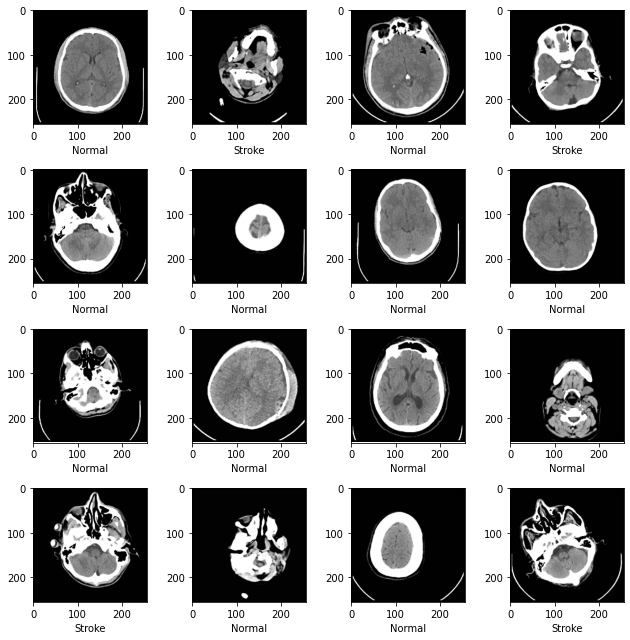

In [ ]:
# show images from dataset
images, labels = next(train_set)[:16]
fig, axes = plt.subplots(4, 4, figsize = (9, 9))

axes = axes.flatten()
for img, label, ax in zip(images, labels, axes):
    ax.imshow(img.reshape(IMAGE_SIZE, IMAGE_SIZE, 3))
    ax.set_xlabel(list(train_set.class_indices)[label.astype(int)])
plt.tight_layout()
plt.show()

# ViT

## Build Model

In [ ]:
# create base model
base_model = ViT(
    image_size = 256,
    patch_size = 32,
    num_classes = 1000,
    dim = 1024,
    depth = 6,
    heads = 16,
    mlp_dim = 2048,
    dropout = 0.1,
    emb_dropout = 0.1
)

# x = base_model.output
# x = tf.keras.layers.GlobalAveragePooling2D()(x)
# predictions = Dense(1, activation = 'sigmoid', name = 'Final')(x)
# model = tf.keras.models.Model(inputs = base_model.input, outputs = predictions)

# model.summary()

AttributeError: ignored

In [ ]:
metrics = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='BinaryAccuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

model.compile(loss = 'binary_crossentropy', 
              optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001, beta_1 = 0.9, beta_2 = 0.999), 
              metrics = metrics)

In [ ]:
def get_callbacks(model_name):
    callbacks = []
    tensor_board = tf.keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=0)
    callbacks.append(tensor_board)
    checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=f'model.{model_name}.h5', verbose=1, monitor='val_loss', mode='min', save_best_only=True)
    callbacks.append(checkpoint)
    anne = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=2, min_lr=0.0000001, min_delta=0.00001, mode='auto') 
    callbacks.append(anne)
    return callbacks

## Train Model

In [ ]:
# train the model
start = datetime.now()
print(datetime.now())

callbacks = get_callbacks('dense121')
history = model.fit(train_set,
                    epochs = NUM_EPOCHS,
                    validation_data = valid_set,
                    callbacks = [callbacks])

end = datetime.now()
print(end-start)

2021-11-20 20:03:00.115719
Epoch 1/20
57/57 [==============================] - ETA: 0s - loss: 0.5282 - tp: 391.0000 - fp: 179.0000 - tn: 962.0000 - fn: 269.0000 - BinaryAccuracy: 0.7512 - precision: 0.6860 - recall: 0.5924 - auc: 0.8078
Epoch 00001: val_loss improved from inf to 1.51939, saving model to model.dense121.h5
57/57 [==============================] - 34s 324ms/step - loss: 0.5282 - tp: 391.0000 - fp: 179.0000 - tn: 962.0000 - fn: 269.0000 - BinaryAccuracy: 0.7512 - precision: 0.6860 - recall: 0.5924 - auc: 0.8078 - val_loss: 1.5194 - val_tp: 32.0000 - val_fp: 0.0000e+00 - val_tn: 285.0000 - val_fn: 133.0000 - val_BinaryAccuracy: 0.7044 - val_precision: 1.0000 - val_recall: 0.1939 - val_auc: 0.6705 - lr: 0.0010
Epoch 2/20
57/57 [==============================] - ETA: 0s - loss: 0.2737 - tp: 545.0000 - fp: 84.0000 - tn: 1057.0000 - fn: 115.0000 - BinaryAccuracy: 0.8895 - precision: 0.8665 - recall: 0.8258 - auc: 0.9500
Epoch 00002: val_loss did not improve from 1.51939
57/57 

## Evaluate Model

In [ ]:
# get results
results = model.evaluate(valid_set, steps = len(valid_set), verbose = 1, return_dict = True)

15/15 [==============================] - 2s 111ms/step - loss: 1.3005 - tp: 94.0000 - fp: 35.0000 - tn: 250.0000 - fn: 71.0000 - BinaryAccuracy: 0.7644 - precision: 0.7287 - recall: 0.5697 - auc: 0.7694


In [ ]:
# show results
print('DenseNet121:')
print('---------------')
print("ACCURACY:",(results['tp']+results['tn'])/(results['tp']+results['tn']+results['fp']+results['fn']))
print("Binary Accuracy:",(results['BinaryAccuracy']))
print("Precision:",(results['precision']))
print("Recall:",(results['recall']))
print("AUC:",(results['auc']))
print("F1 Score:",(2*((results['precision']*results['recall'])/((results['precision']+results['recall'])))))

DenseNet121:
---------------
ACCURACY: 0.7644444444444445
Binary Accuracy: 0.7644444704055786
Precision: 0.7286821603775024
Recall: 0.5696969628334045
AUC: 0.7694311141967773
F1 Score: 0.6394557740751876


## Predict


Classification Report
              precision    recall  f1-score   support

      Normal       0.67      0.90      0.77       125
      Stroke       0.85      0.55      0.67       125

    accuracy                           0.73       250
   macro avg       0.76      0.73      0.72       250
weighted avg       0.76      0.73      0.72       250

Confusion Matrix
[[113  12]
 [ 56  69]]


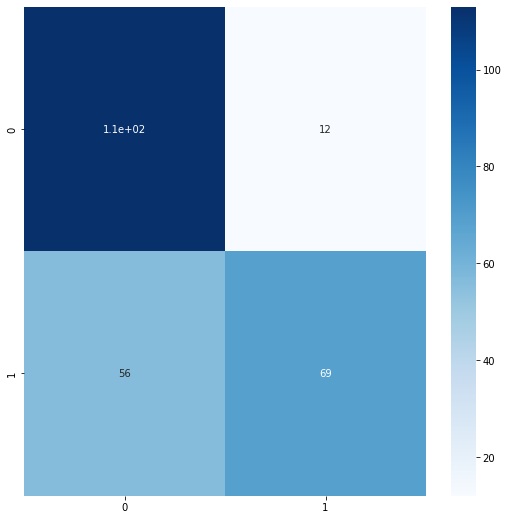

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

Y_pred = model.predict(test_set)
y_pred = (Y_pred > 0.8).astype("int32")

print('\nClassification Report')
target_names = ['Normal', 'Stroke']
print(classification_report(test_set.classes, y_pred, target_names = target_names))

confusion_matrix = confusion_matrix(test_set.classes, y_pred)
print('Confusion Matrix')
print(confusion_matrix)

plt.figure(figsize = (9, 9))
sns.heatmap(confusion_matrix, cmap = 'Blues', annot = True, cbar = True)

# ResNet50

## Build Model

In [ ]:
# create ResNet50 base model
base_model = tf.keras.applications.ResNet50(
    input_shape = INPUT_SHAPE,
    include_top = False,
    weights = 'imagenet')
base_model.trainable = True

x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
predictions = Dense(1, activation = 'sigmoid', name = 'Final')(x)
model = tf.keras.models.Model(inputs = base_model.input, outputs = predictions)

model.summary()

94781440/94765736 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                             

In [ ]:
metrics = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='BinaryAccuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

model.compile(loss = 'binary_crossentropy', 
              optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001, beta_1 = 0.9, beta_2 = 0.999), 
              metrics = metrics)

## Train Model

In [ ]:
# train the model
start = datetime.now()
print(datetime.now())

callbacks = get_callbacks('resnet50')
history = model.fit(train_set,
                    epochs = NUM_EPOCHS,
                    validation_data = valid_set,
                    callbacks = [callbacks])

end = datetime.now()
print(end-start)

2021-11-20 19:25:15.959189


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 1/20
57/57 [==============================] - ETA: 0s - loss: 0.5818 - tp: 368.0000 - fp: 190.0000 - tn: 951.0000 - fn: 292.0000 - BinaryAccuracy: 0.7324 - precision: 0.6595 - recall: 0.5576 - auc: 0.7808
Epoch 00001: val_loss improved from inf to 0.68106, saving model to model.resnet50.h5
57/57 [==============================] - 16s 283ms/step - loss: 0.5818 - tp: 368.0000 - fp: 190.0000 - tn: 951.0000 - fn: 292.0000 - BinaryAccuracy: 0.7324 - precision: 0.6595 - recall: 0.5576 - auc: 0.7808 - val_loss: 0.6811 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 285.0000 - val_fn: 165.0000 - val_BinaryAccuracy: 0.6333 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.3798 - lr: 0.0010
Epoch 2/20
57/57 [==============================] - ETA: 0s - loss: 0.2383 - tp: 560.0000 - fp: 73.0000 - tn: 1068.0000 - fn: 100.0000 - BinaryAccuracy: 0.9039 - precision: 0.8847 - recall: 0.8485 - auc: 0.9635
Epoch 00002: val_loss did not improve from 0.68106
57/57 [===============

## Evaluate Model

In [ ]:
# get results
results = model.evaluate(valid_set, steps = len(valid_set), verbose = 1, return_dict = True)

15/15 [==============================] - 2s 112ms/step - loss: 0.8562 - tp: 108.0000 - fp: 49.0000 - tn: 236.0000 - fn: 57.0000 - BinaryAccuracy: 0.7644 - precision: 0.6879 - recall: 0.6545 - auc: 0.8057


In [ ]:
# show results
print('ResNet50:')
print('---------------')
print("ACCURACY:",(results['tp']+results['tn'])/(results['tp']+results['tn']+results['fp']+results['fn']))
print("Binary Accuracy:",(results['BinaryAccuracy']))
print("Precision:",(results['precision']))
print("Recall:",(results['recall']))
print("AUC:",(results['auc']))
print("F1 Score:",(2*((results['precision']*results['recall'])/((results['precision']+results['recall'])))))

ResNet50:
---------------
ACCURACY: 0.7644444444444445
Binary Accuracy: 0.7644444704055786
Precision: 0.6878980994224548
Recall: 0.6545454263687134
AUC: 0.8056672215461731
F1 Score: 0.6708074434927719


## Predict


Classification Report
              precision    recall  f1-score   support

      Normal       0.76      0.94      0.84       125
      Stroke       0.92      0.71      0.80       125

    accuracy                           0.82       250
   macro avg       0.84      0.82      0.82       250
weighted avg       0.84      0.82      0.82       250

Confusion Matrix
[[117   8]
 [ 36  89]]


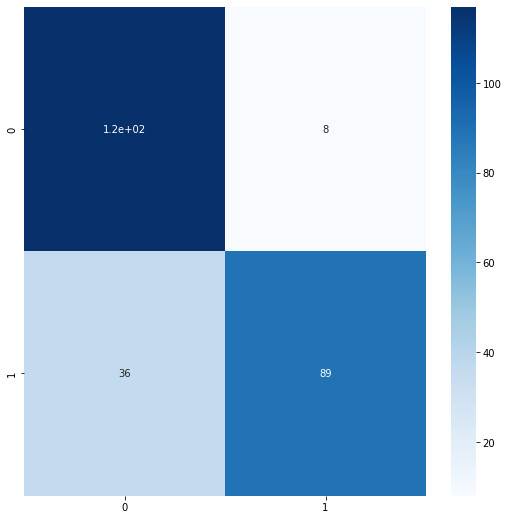

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

Y_pred = model.predict(test_set)
y_pred = (Y_pred > 0.8).astype("int32")

print('\nClassification Report')
target_names = ['Normal', 'Stroke']
print(classification_report(test_set.classes, y_pred, target_names = target_names))

confusion_matrix = confusion_matrix(test_set.classes, y_pred)
print('Confusion Matrix')
print(confusion_matrix)

plt.figure(figsize = (9, 9))
sns.heatmap(confusion_matrix, cmap = 'Blues', annot = True, cbar = True)

# VGG16

## Build Model

In [ ]:
# create VGG16 base model
base_model = tf.keras.applications.VGG16(
    input_shape = INPUT_SHAPE,
    include_top = False,
    weights = 'imagenet')
base_model.trainable = True

x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
predictions = Dense(1, activation = 'sigmoid', name = 'Final')(x)
model = tf.keras.models.Model(inputs = base_model.input, outputs = predictions)

model.summary()

58900480/58889256 [==============================] - 1s 0us/step
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

In [ ]:
metrics = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='BinaryAccuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

model.compile(loss = 'binary_crossentropy', 
              optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001, beta_1 = 0.9, beta_2 = 0.999), 
              metrics = metrics)

## Train Model

In [ ]:
# train the model
start = datetime.now()
print(datetime.now())

callbacks = get_callbacks('vgg16')
history = model.fit(train_set,
                    epochs = NUM_EPOCHS,
                    validation_data = valid_set,
                    callbacks = [callbacks])

end = datetime.now()
print(end-start)

2021-11-20 19:30:29.966882
Epoch 1/20
57/57 [==============================] - ETA: 0s - loss: 2.5056 - tp: 46.0000 - fp: 66.0000 - tn: 1075.0000 - fn: 614.0000 - BinaryAccuracy: 0.6224 - precision: 0.4107 - recall: 0.0697 - auc: 0.4978
Epoch 00001: val_loss improved from inf to 0.66733, saving model to model.vgg16.h5
57/57 [==============================] - 25s 300ms/step - loss: 2.5056 - tp: 46.0000 - fp: 66.0000 - tn: 1075.0000 - fn: 614.0000 - BinaryAccuracy: 0.6224 - precision: 0.4107 - recall: 0.0697 - auc: 0.4978 - val_loss: 0.6673 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 285.0000 - val_fn: 165.0000 - val_BinaryAccuracy: 0.6333 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5708 - lr: 0.0010
Epoch 2/20
57/57 [==============================] - ETA: 0s - loss: 0.6681 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 1141.0000 - fn: 660.0000 - BinaryAccuracy: 0.6335 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5087
Epoch 00002: val_loss improved from 0.

## Evaluate Model

In [ ]:
# get results
results = model.evaluate(valid_set, steps = len(valid_set), verbose = 1, return_dict = True)

15/15 [==============================] - 2s 108ms/step - loss: 0.8691 - tp: 46.0000 - fp: 64.0000 - tn: 221.0000 - fn: 119.0000 - BinaryAccuracy: 0.5933 - precision: 0.4182 - recall: 0.2788 - auc: 0.5571


In [ ]:
# show results
print('VGG16:')
print('---------------')
print("ACCURACY:",(results['tp']+results['tn'])/(results['tp']+results['tn']+results['fp']+results['fn']))
print("Binary Accuracy:",(results['BinaryAccuracy']))
print("Precision:",(results['precision']))
print("Recall:",(results['recall']))
print("AUC:",(results['auc']))
print("F1 Score:",(2*((results['precision']*results['recall'])/((results['precision']+results['recall'])))))

VGG16:
---------------
ACCURACY: 0.5933333333333334
Binary Accuracy: 0.5933333039283752
Precision: 0.41818180680274963
Recall: 0.27878788113594055
AUC: 0.557086706161499
F1 Score: 0.334545452594757


## Predict


Classification Report
              precision    recall  f1-score   support

      Normal       0.51      1.00      0.67       125
      Stroke       1.00      0.03      0.06       125

    accuracy                           0.52       250
   macro avg       0.75      0.52      0.37       250
weighted avg       0.75      0.52      0.37       250

Confusion Matrix
[[125   0]
 [121   4]]


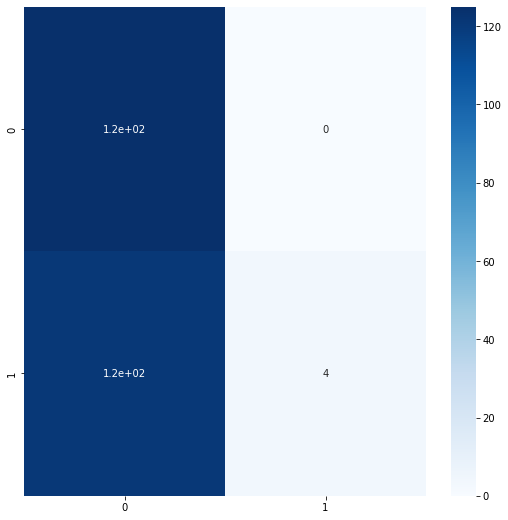

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

Y_pred = model.predict(test_set)
y_pred = (Y_pred > 0.8).astype("int32")

print('\nClassification Report')
target_names = ['Normal', 'Stroke']
print(classification_report(test_set.classes, y_pred, target_names = target_names))

confusion_matrix = confusion_matrix(test_set.classes, y_pred)
print('Confusion Matrix')
print(confusion_matrix)

plt.figure(figsize = (9, 9))
sns.heatmap(confusion_matrix, cmap = 'Blues', annot = True, cbar = True)

# InceptionV3

## Build Model

In [ ]:
INPUT_SHAPE = (299, 299, 3)

# create InceptionV3 base model
base_model = tf.keras.applications.InceptionV3(
    input_shape = INPUT_SHAPE,
    include_top = False,
    weights = 'imagenet')
base_model.trainable = True

x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
predictions = Dense(1, activation = 'sigmoid', name = 'Final')(x)
model = tf.keras.models.Model(inputs = base_model.input, outputs = predictions)

model.summary()

87924736/87910968 [==============================] - 1s 0us/step
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                

In [ ]:
metrics = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='BinaryAccuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

model.compile(loss = 'binary_crossentropy', 
              optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001, beta_1 = 0.9, beta_2 = 0.999), 
              metrics = metrics)

## Train Model

In [ ]:
# train the model
start = datetime.now()
print(datetime.now())

callbacks = get_callbacks('inceptionv3')
history = model.fit(train_set,
                    epochs = NUM_EPOCHS,
                    validation_data = valid_set,
                    callbacks = [callbacks])

end = datetime.now()
print(end-start)

2021-11-20 19:37:51.948180
Epoch 1/20
57/57 [==============================] - ETA: 0s - loss: 0.7045 - tp: 79.0000 - fp: 113.0000 - tn: 1028.0000 - fn: 581.0000 - BinaryAccuracy: 0.6147 - precision: 0.4115 - recall: 0.1197 - auc: 0.6103
Epoch 00001: val_loss improved from inf to 6.43458, saving model to model.inceptionv3.h5
57/57 [==============================] - 26s 267ms/step - loss: 0.7045 - tp: 79.0000 - fp: 113.0000 - tn: 1028.0000 - fn: 581.0000 - BinaryAccuracy: 0.6147 - precision: 0.4115 - recall: 0.1197 - auc: 0.6103 - val_loss: 6.4346 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 285.0000 - val_fn: 165.0000 - val_BinaryAccuracy: 0.6333 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4938 - lr: 0.0010
Epoch 2/20
57/57 [==============================] - ETA: 0s - loss: 0.5363 - tp: 318.0000 - fp: 182.0000 - tn: 959.0000 - fn: 342.0000 - BinaryAccuracy: 0.7091 - precision: 0.6360 - recall: 0.4818 - auc: 0.7767
Epoch 00002: val_loss improved from 6.43458

## Evaluate Model

In [ ]:
# get results
results = model.evaluate(valid_set, steps = len(valid_set), verbose = 1, return_dict = True)

15/15 [==============================] - 2s 110ms/step - loss: 1.5641 - tp: 61.0000 - fp: 7.0000 - tn: 278.0000 - fn: 104.0000 - BinaryAccuracy: 0.7533 - precision: 0.8971 - recall: 0.3697 - auc: 0.7588


In [ ]:
# show results
print('InceptionV3:')
print('---------------')
print("ACCURACY:",(results['tp']+results['tn'])/(results['tp']+results['tn']+results['fp']+results['fn']))
print("Binary Accuracy:",(results['BinaryAccuracy']))
print("Precision:",(results['precision']))
print("Recall:",(results['recall']))
print("AUC:",(results['auc']))
print("F1 Score:",(2*((results['precision']*results['recall'])/((results['precision']+results['recall'])))))

InceptionV3:
---------------
ACCURACY: 0.7533333333333333
Binary Accuracy: 0.753333330154419
Precision: 0.8970588445663452
Recall: 0.3696969747543335
AUC: 0.7587984800338745
F1 Score: 0.523605158870545


## Predict


Classification Report
              precision    recall  f1-score   support

      Normal       0.62      0.91      0.74       125
      Stroke       0.84      0.45      0.58       125

    accuracy                           0.68       250
   macro avg       0.73      0.68      0.66       250
weighted avg       0.73      0.68      0.66       250

Confusion Matrix
[[114  11]
 [ 69  56]]


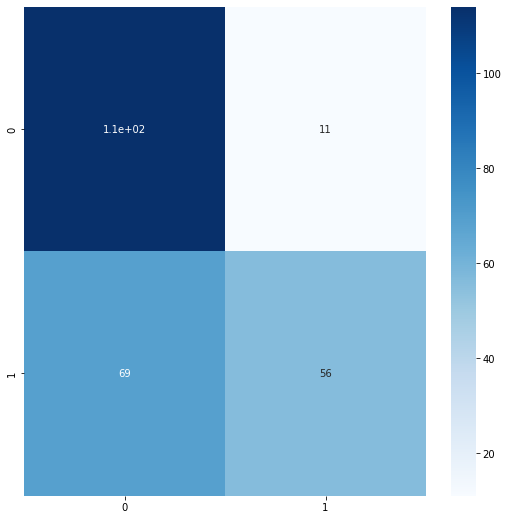

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

Y_pred = model.predict(test_set)
y_pred = (Y_pred > 0.8).astype("int32")

print('\nClassification Report')
target_names = ['Normal', 'Stroke']
print(classification_report(test_set.classes, y_pred, target_names = target_names))

confusion_matrix = confusion_matrix(test_set.classes, y_pred)
print('Confusion Matrix')
print(confusion_matrix)

plt.figure(figsize = (9, 9))
sns.heatmap(confusion_matrix, cmap = 'Blues', annot = True, cbar = True)

# MobileNet

## Build Model

In [ ]:
INPUT_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)

# create MobileNet base model
base_model = tf.keras.applications.MobileNet(
    input_shape = INPUT_SHAPE,
    include_top = False,
    weights = 'imagenet')
base_model.trainable = True

x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
predictions = Dense(1, activation = 'sigmoid', name = 'Final')(x)
model = tf.keras.models.Model(inputs = base_model.input, outputs = predictions)

model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                                    

In [ ]:
metrics = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='BinaryAccuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

model.compile(loss = 'binary_crossentropy', 
              optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001, beta_1 = 0.9, beta_2 = 0.999), 
              metrics = metrics)

## Train Model

In [ ]:
# train the model
start = datetime.now()
print(datetime.now())

callbacks = get_callbacks('mobilenet')
history = model.fit(train_set,
                    epochs = NUM_EPOCHS,
                    validation_data = valid_set,
                    callbacks = [callbacks])

end = datetime.now()
print(end-start)

2021-11-20 19:54:58.451582
Epoch 1/20
57/57 [==============================] - ETA: 0s - loss: 0.5265 - tp: 454.0000 - fp: 194.0000 - tn: 947.0000 - fn: 206.0000 - BinaryAccuracy: 0.7779 - precision: 0.7006 - recall: 0.6879 - auc: 0.8482
Epoch 00001: val_loss improved from inf to 2.82922, saving model to model.mobilenet.h5
57/57 [==============================] - 17s 211ms/step - loss: 0.5265 - tp: 454.0000 - fp: 194.0000 - tn: 947.0000 - fn: 206.0000 - BinaryAccuracy: 0.7779 - precision: 0.7006 - recall: 0.6879 - auc: 0.8482 - val_loss: 2.8292 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 285.0000 - val_fn: 165.0000 - val_BinaryAccuracy: 0.6333 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5561 - lr: 0.0010
Epoch 2/20
57/57 [==============================] - ETA: 0s - loss: 0.1590 - tp: 607.0000 - fp: 46.0000 - tn: 1095.0000 - fn: 53.0000 - BinaryAccuracy: 0.9450 - precision: 0.9296 - recall: 0.9197 - auc: 0.9808
Epoch 00002: val_loss improved from 2.82922 to

## Evaluate Model

In [ ]:
# get results
results = model.evaluate(valid_set, steps = len(valid_set), verbose = 1, return_dict = True)

15/15 [==============================] - 2s 98ms/step - loss: 1.7129 - tp: 80.0000 - fp: 25.0000 - tn: 260.0000 - fn: 85.0000 - BinaryAccuracy: 0.7556 - precision: 0.7619 - recall: 0.4848 - auc: 0.7621


In [ ]:
# show results
print('MobileNet:')
print('---------------')
print("ACCURACY:",(results['tp']+results['tn'])/(results['tp']+results['tn']+results['fp']+results['fn']))
print("Binary Accuracy:",(results['BinaryAccuracy']))
print("Precision:",(results['precision']))
print("Recall:",(results['recall']))
print("AUC:",(results['auc']))
print("F1 Score:",(2*((results['precision']*results['recall'])/((results['precision']+results['recall'])))))

MobileNet:
---------------
ACCURACY: 0.7555555555555555
Binary Accuracy: 0.7555555701255798
Precision: 0.761904776096344
Recall: 0.4848484992980957
AUC: 0.7620946168899536
F1 Score: 0.5925926076777187


## Predict


Classification Report
              precision    recall  f1-score   support

      Normal       0.67      0.90      0.76       125
      Stroke       0.84      0.55      0.67       125

    accuracy                           0.72       250
   macro avg       0.75      0.72      0.72       250
weighted avg       0.75      0.72      0.72       250

Confusion Matrix
[[112  13]
 [ 56  69]]


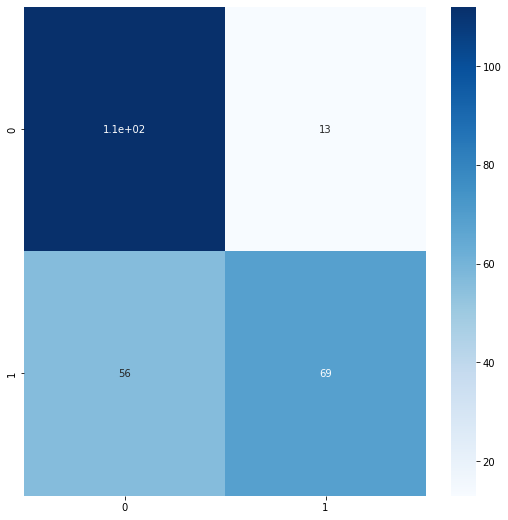

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

Y_pred = model.predict(test_set)
y_pred = (Y_pred > 0.8).astype("int32")

print('\nClassification Report')
target_names = ['Normal', 'Stroke']
print(classification_report(test_set.classes, y_pred, target_names = target_names))

confusion_matrix = confusion_matrix(test_set.classes, y_pred)
print('Confusion Matrix')
print(confusion_matrix)

plt.figure(figsize = (9, 9))
sns.heatmap(confusion_matrix, cmap = 'Blues', annot = True, cbar = True)